# Project Description

Goal: Optimizing marketing expenses

Data used:
 - Server logs with data on the companys website visits from June 2017 through May 2018
 - Dump file with all orders for the period
 - Marketing expenses statistics

Conclusions:
 - How people use the product
 - When they start to buy
 - How much money each customer brings
 - When they pay off

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

%matplotlib inline

In [51]:
#loading dataframes
visits_logs = pd.read_csv(r'/datasets/visits_log_us.csv')

orders = pd.read_csv(r'/datasets/orders_log_us.csv')

marketing_costs = pd.read_csv(r'/datasets/costs_us.csv')

#printing dataframes info
print('visits info')
visits_logs.info(memory_usage='deep')
print()

print('orders info')
orders.info(memory_usage='deep')
print()

print('marketing costs info')
marketing_costs.info(memory_usage='deep')
print()

visits info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 79.3 MB

orders info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 4.4 MB

marketing costs info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 206.2 KB



In [52]:
#Changing data types

#For visits logs
visits_logs.columns = visits_logs.columns.str.lower()
visits_logs['device'].value_counts()
visits_logs['device'] = visits_logs['device'].astype('category')
visits_logs['start ts'] = pd.to_datetime(visits_logs['start ts'])
visits_logs['end ts'] = pd.to_datetime(visits_logs['end ts'])
visits_logs['source id'] = visits_logs['source id'].astype('category')

#For orders
orders.columns = orders.columns.str.lower()
orders['buy ts'] = pd.to_datetime(orders['buy ts'])

#For marketing costs
marketing_costs['source_id'].value_counts()
marketing_costs['source_id'] = marketing_costs['source_id'].astype('category')
marketing_costs['dt'] = pd.to_datetime(marketing_costs['dt'])

#Changing columns names

orders.columns = ['buy_ts','revenue','uid']
visits_logs.columns = ['device','end_ts','source_id','start_ts','uid']

In [53]:
#Checking everything worked out fine

print('visits info')
visits_logs.info(memory_usage='deep')
print()

print('orders info')
orders.info(memory_usage='deep')
print()

print('marketing costs info')
marketing_costs.info(memory_usage='deep')

visits info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null category
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null category
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: category(2), datetime64[ns](2), uint64(1)
memory usage: 8.9 MB

orders info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB

marketing costs info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null category
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 42

## Cleaning the data

In [54]:
orders.describe()

,revenue,uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


2520.75
2500


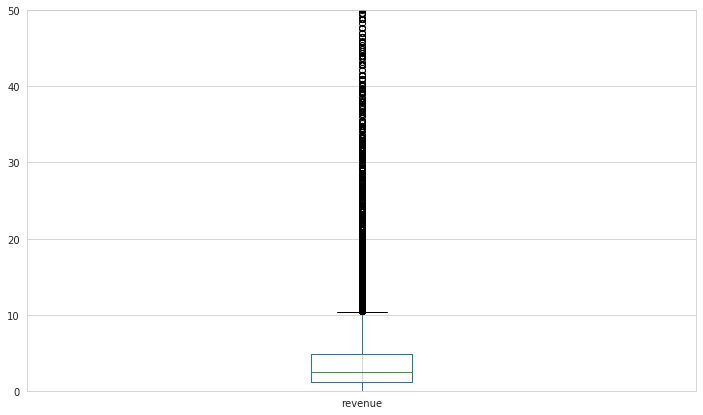

In [55]:
#getting how much is 5% of the data
fiveprecent = len(orders)*0.05
print(fiveprecent)
#we can drop 2520 data points
#checking how much data points we drop without outliers

print(len(orders) - len(orders.loc[orders['revenue']<14]))

#95% of our revenue data is smaller than 14

orders['revenue'].plot(kind='box', ylim=(0,50),grid=True,figsize=(12,7))

In [56]:
#getting corrected data
orders_fixed = orders.loc[orders['revenue']<14].copy()

In [57]:
#cleaning marketing costs
marketing_costs.describe()

,costs
count,2542.000000
mean,129.477427
std,156.296628
min,0.540000
25%,21.945000
50%,77.295000
75%,170.065000
max,1788.280000


127.10000000000001
105


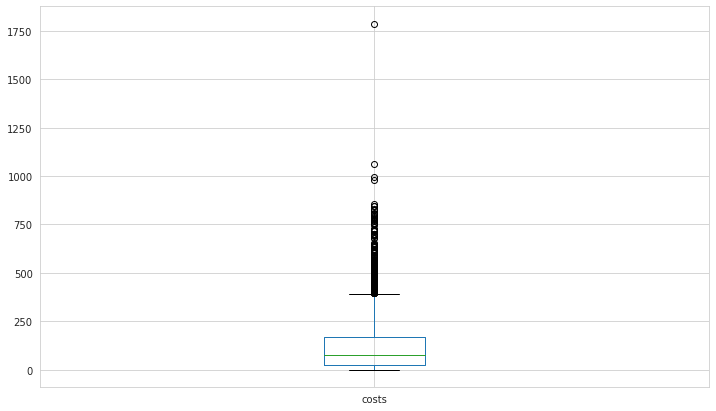

In [58]:
#getting how much is 5% of the data
fiveprecent = len(marketing_costs)*0.05
print(fiveprecent)

#we can drop 127 data points
#checking how much data points we drop without outliers
print(len(marketing_costs) - len(marketing_costs.loc[marketing_costs['costs']<500]))

#around 95% of our costs data is smaller than 500
marketing_costs['costs'].plot(kind='box',grid=True,figsize=(12,7))

In [59]:
#getting corrected data
marketing_fixed = marketing_costs.loc[marketing_costs['costs']<500].copy()

## Product

In [60]:
#How many people are visiting each day/week/month

visits_logs.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [61]:
#Getting specific metrics for the visits
visits_logs['day'] = visits_logs['start_ts'].dt.day
visits_logs['week'] = visits_logs['start_ts'].dt.week
visits_logs['month'] = visits_logs['start_ts'].dt.month
visits_logs['year'] = visits_logs['start_ts'].dt.year
visits_logs['session_date'] = visits_logs['start_ts'].dt.date
visits_logs['time_on_site'] = (visits_logs['end_ts'] - visits_logs['start_ts']).dt.seconds
visits_logs['first_visit'] = visits_logs.groupby(['uid'])['start_ts'].transform('min').astype('datetime64[D]')

visits_logs.head()


,device,end_ts,source_id,start_ts,uid,day,week,month,year,session_date,time_on_site,first_visit
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,20,51,12,2017,2017-12-20,1080,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,19,8,2,2018,2018-02-19,1680,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,1,26,7,2017,2017-07-01,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,20,20,5,2018,2018-05-20,1440,2018-03-09
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,27,52,12,2017,2017-12-27,0,2017-12-27


In [62]:
#Daily, Weekly and Monthly active users
DAU_table = visits_logs.groupby('session_date').agg({'uid':'nunique'})
DAU = DAU_table['uid'].mean()

WAU = visits_logs.groupby(['year','week']).agg({'uid':'nunique'})
WAU = WAU['uid'].mean()

MAU = visits_logs.groupby(['year','month']).agg({'uid':'nunique'})
MAU = MAU['uid'].mean()

print("Daily active users on avg:", int(DAU))

print("Weekly active users on avg:", int(WAU))

print("Monthly active users on avg:", int(MAU))

Daily active users on avg: 907
Weekly active users on avg: 5716
Monthly active users on avg: 23228


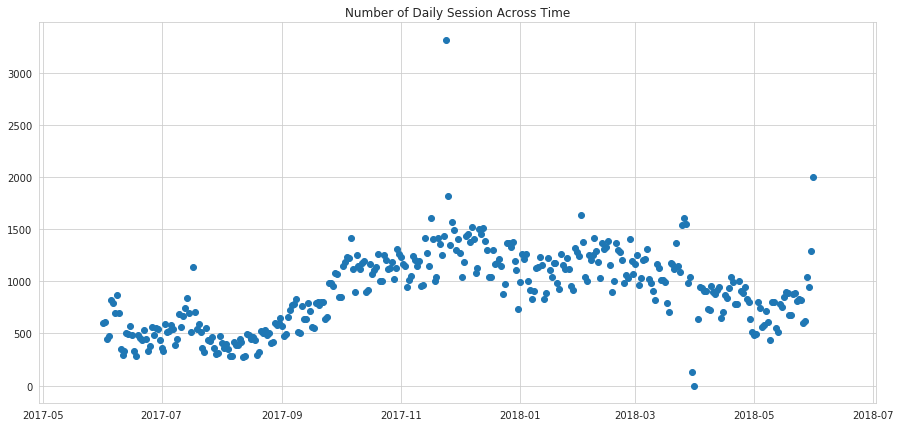

In [63]:
#getting the daily sessions across time

daily_session_across_time = visits_logs.groupby('session_date').agg({'uid':'nunique'}).reset_index()
#daily_session_across_time.plot(x='session_date',y='uid',kind='scatter', figsize=(15,7), title='Daily Session Across Time', grid=True)
plt.figure(figsize=(15,7))
plt.title('Number of Daily Session Across Time')
plt.grid(True)
plt.scatter(x=daily_session_across_time['session_date'],y=daily_session_across_time['uid'])
plt.show()


In [64]:
#Sessions per day
sessions_per_day = visits_logs.groupby('session_date').agg({'uid':['count','nunique']})
sessions_per_day.columns = ['sessions', 'unique_sessions']

print("Avg Total Session per Day", int(sessions_per_day['sessions'].mean()))
print("Avg Unique Session per Day", int(sessions_per_day['unique_sessions'].mean()))

Avg Total Session per Day 987
Avg Unique Session per Day 907


Average Session Time: 621 Seconds


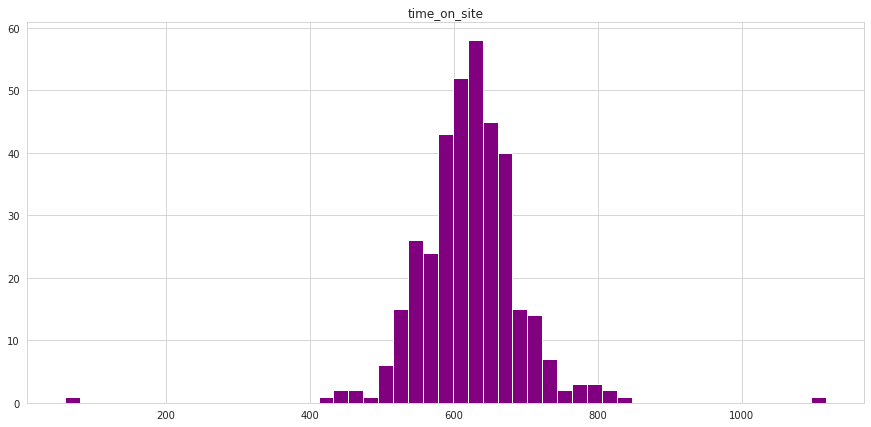

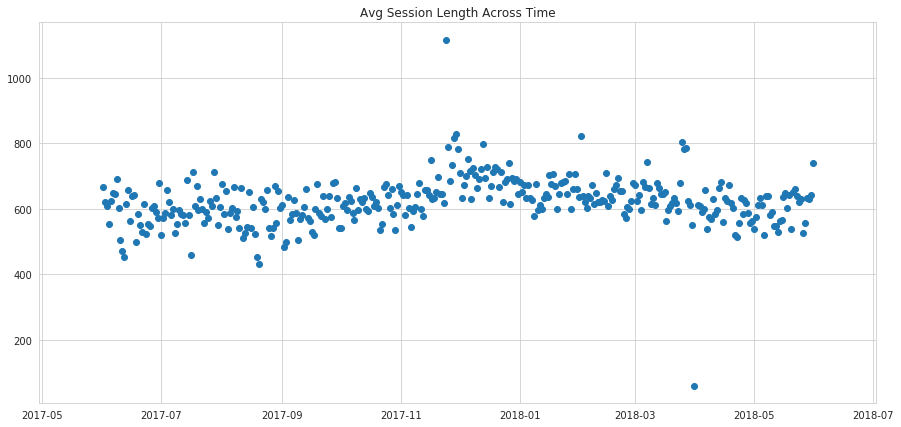

In [65]:
#Average session time
avg_session = visits_logs.groupby('session_date').agg({'time_on_site':'mean'}).reset_index()
avg_session_time = avg_session['time_on_site'].mean()

print('Average Session Time:', int(avg_session_time), "Seconds")


avg_session.hist(bins='auto', figsize=(15,7), color='purple')
plt.show()

plt.figure(figsize=(15,7))
plt.title('Avg Session Length Across Time')
plt.grid(True)
plt.scatter(x=avg_session['session_date'],y=avg_session['time_on_site'])
plt.show()


In [66]:
#Sticky factor - how many users come back?

stick = round(((DAU/MAU)*100),2)
stick2 = round(((DAU/WAU)*100),2)
print(stick,'% of the daily users come back each month')
print(stick2,'% of the daily users come back each week')

3.91 % of the daily users come back each month
15.88 % of the daily users come back each week


### Conclusions

 -  Daily Active Users on Avg: 907


 -  Weekly Active Users on Avg: 5716


 -  Monthly Active Users on Avg: 23228


 -  Avg Number of Session per Day 987


 -  Avg Number of Unique Session per Day 907


 -  Average Session Time: 621 seconds (10.35 minutes)


 -  3.91% of the daily users come back each month


 -  15.88 % of the daily users come back each week

## Sales


In [67]:
#When people start buying?

#Getting the first buys for each user
orders_fixed['first_buy'] = orders.groupby(['uid'])['buy_ts'].transform('min').astype('datetime64[D]')

#slicing the data
orders_slice = orders_fixed[['uid','first_buy']].copy()

In [68]:
#Slicing visits data so i get only the data needed
first_visits_slice = visits_logs[['device','first_visit','uid','source_id','time_on_site']]

#merging the data to a converstion table
conversions = pd.merge(first_visits_slice,orders_slice, how='inner', on='uid')
conversions['days_to_convert'] = (conversions['first_buy'] - conversions['first_visit']).dt.days
conversions['first_visit_month'] = conversions['first_visit'].dt.month
conversions['first_visit_year'] = conversions['first_visit'].dt.year
conversions.head()

,device,first_visit,uid,source_id,time_on_site,first_buy,days_to_convert,first_visit_month,first_visit_year
0,desktop,2018-03-09,16174680259334210214,9,1440,2018-03-09,0,3,2018
1,desktop,2018-03-09,16174680259334210214,4,1680,2018-03-09,0,3,2018
2,desktop,2017-09-03,16007536194108375387,5,60,2017-09-04,1,9,2017
3,desktop,2017-09-03,16007536194108375387,5,60,2017-09-04,1,9,2017
4,desktop,2017-09-03,16007536194108375387,5,60,2017-09-04,1,9,2017


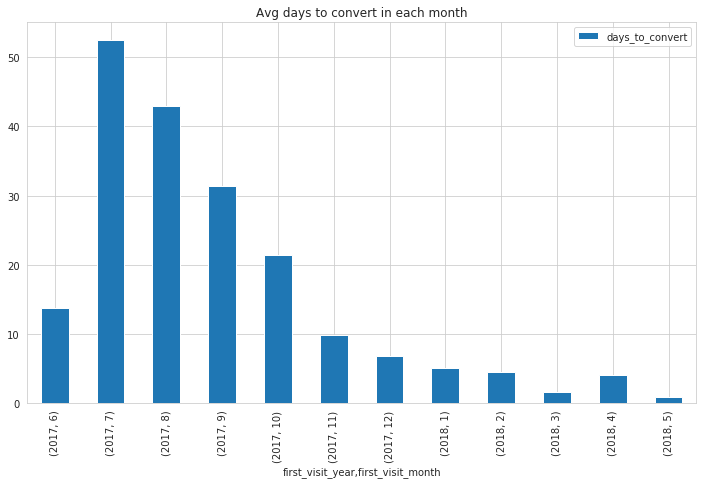

In [69]:
#Plotting the avg days to convert in each cohort
conversions_pt = conversions.pivot_table(index=['first_visit_year','first_visit_month'], values=['days_to_convert'], aggfunc='mean')

conversions_pt.plot(kind='bar', figsize=(12,7), title='Avg days to convert in each month',grid=True)

Since July 2017 there has been a decrease in the average time to convert.

The most converting months were March and May 2018


In [70]:
#Checking the best/worst conversions rates so we can know for sure that the platforms are responsible for the change and not other things such as the creative work of the ads
conversions_best_ads = conversions.loc[(conversions['first_visit_year'] == 2018) & ((conversions['first_visit_month']==3) | (conversions['first_visit_month']==5))]
print("Best Platforms: \n", conversions_best_ads['source_id'].value_counts())

print()

conversions_worst_ads = conversions.loc[(conversions['first_visit_year'] == 2017) & ((conversions['first_visit_month']==7) | (conversions['first_visit_month']==8))]
print("Worst Platforms: \n",conversions_worst_ads['source_id'].value_counts())

Best Platforms: 
 2     12600
5      8779
1      8407
3      3674
4      2987
10      456
9       381
7         0
6         0
Name: source_id, dtype: int64

Worst Platforms: 
 5     20290
1     16639
2     14117
4      6804
3      4481
9      2031
10      530
7         1
6         0
Name: source_id, dtype: int64


The platforms didnt change greatly that means that the marketing team changed their work inside these platform. Another option is that people are more familier with our site and therefore feel more confident to make a purchase.
 

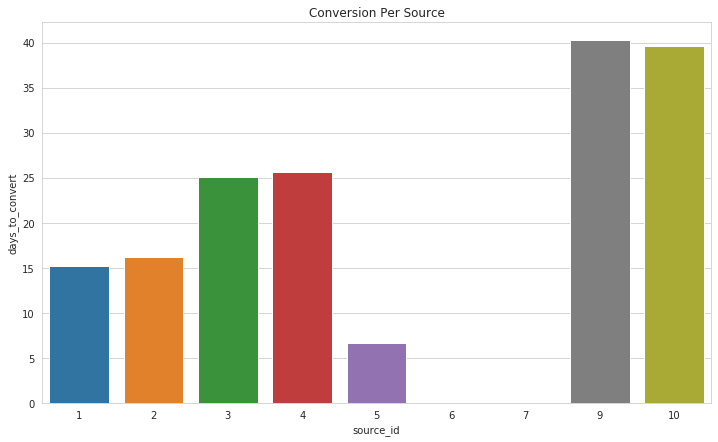

In [71]:
#Getting which source is most converting

best_ads = conversions.pivot_table(index='source_id', values='days_to_convert').reset_index()

plt.figure(figsize=(12,7))
sns.set_style('whitegrid')
sns.barplot(x='source_id', y='days_to_convert', data=best_ads).set(title='Conversion Per Source')
plt.show()

The most converting sources are 1,2 and 5

the worst converting sources are 9 and 10 following 3 and 4.

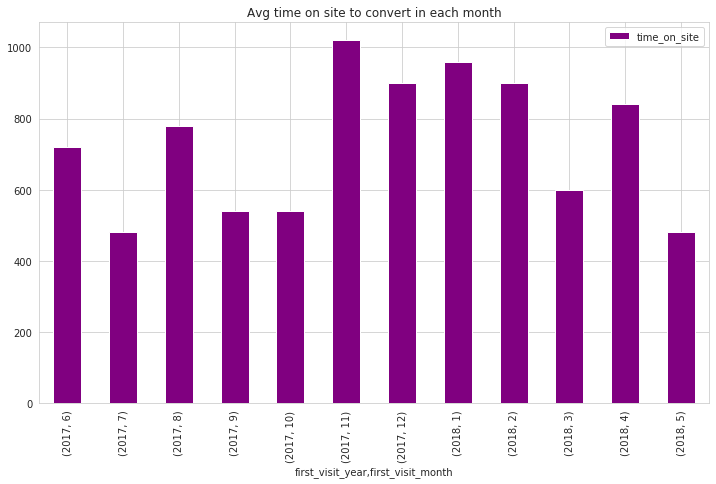

In [72]:
#Time spent on site before buying per cohort

#time_on_site_table = tost 

tost_pt = conversions.pivot_table(index=['first_visit_year','first_visit_month'], values=['time_on_site'], aggfunc='median')

tost_pt.plot(kind='bar', figsize=(12,7), title='Avg time on site to convert in each month', grid=True, color='purple')
plt.show()

July and September 2017 needed the least time to be on the site before converting. 
the marketing team should check the website design and if something had changed   

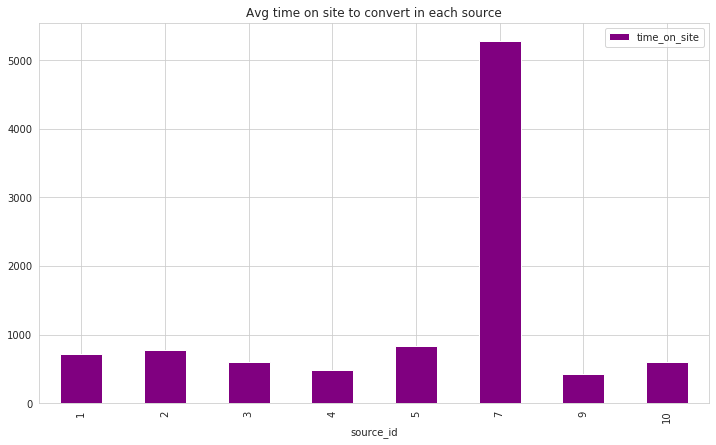

In [73]:
#Time spent on site before buying per source

#time_on_site_table = tost 

tost_pt_source = conversions.pivot_table(index='source_id', values=['time_on_site'], aggfunc='median')

tost_pt_source.plot(kind='bar', figsize=(12,7), title='Avg time on site to convert in each source', grid=True, color='purple')
plt.show()

In almost all the sources the customers needed around 800 seconds on site before making a purchase (except for source 7 which needed 7000 seconds on site)

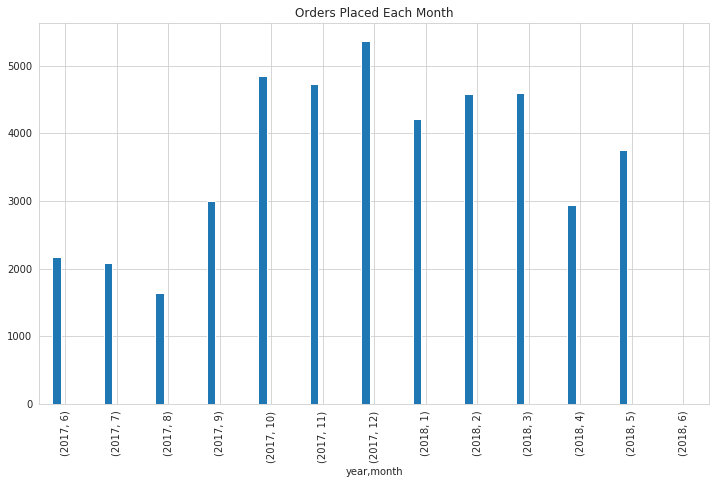

In [74]:
#How many orders people place each month

orders_fixed['month'] = orders_fixed['buy_ts'].dt.month
orders_fixed['year'] = orders_fixed['buy_ts'].dt.year

orders_pt = orders_fixed.pivot_table(index=['year','month'], values='buy_ts', aggfunc='nunique')

orders_pt.plot(kind='bar', figsize=(12,7), legend=False, title='Orders Placed Each Month', grid=True)
plt.show()

There is a small increase in Spetember 2017 cohort following a big increase in the lster cohorts until March 2018. 
This increase in maybe due to the beginning of winter season where people prefer to hang out in closed placed rather open places. 

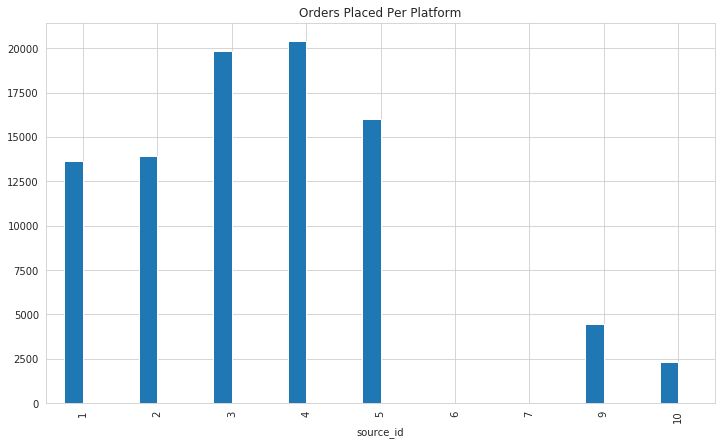

In [75]:
#How many orders were done from each platform in total
visits_source_slice = visits_logs[['uid','source_id']]
orders_source = pd.merge(orders_fixed ,visits_source_slice, how='inner',on='uid')

orders_source_pt = orders_source.pivot_table(index='source_id', values='buy_ts', aggfunc='nunique')

orders_source_pt.plot(kind='bar', figsize=(12,7), legend=False, title='Orders Placed Per Platform', grid=True)
plt.show()

Sources 3 and 4 had the most orders from them.
following sources 5,2 and 1.

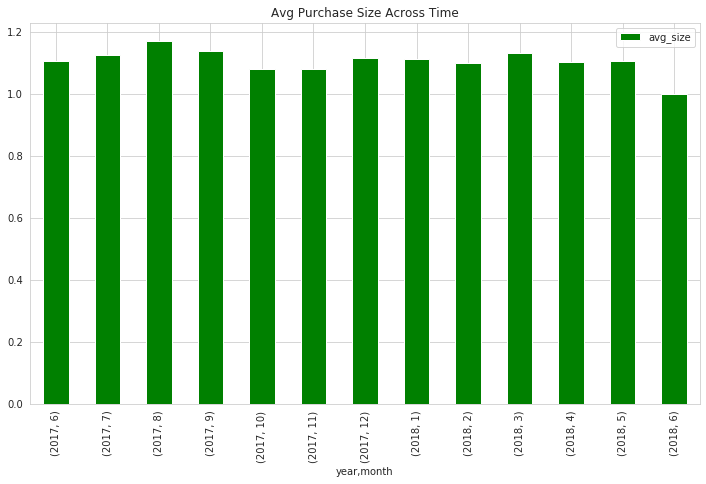

In [76]:
#The average purchese size across time
orders_monthly_pt = orders_fixed.pivot_table(index=['year','month'], values=['uid','buy_ts'], aggfunc={'uid':'nunique','buy_ts':'nunique'})
orders_monthly_pt['avg_size'] = orders_monthly_pt['buy_ts']/orders_monthly_pt['uid']
orders_monthly_pt.drop(columns=['buy_ts','uid'], inplace=True)
orders_monthly_pt.plot(kind='bar', figsize=(12,7), legend=True, title='Avg Purchase Size Across Time', grid=True, color='green')
plt.show()

The average purchase size for all the cohorts stands at around 1.1 

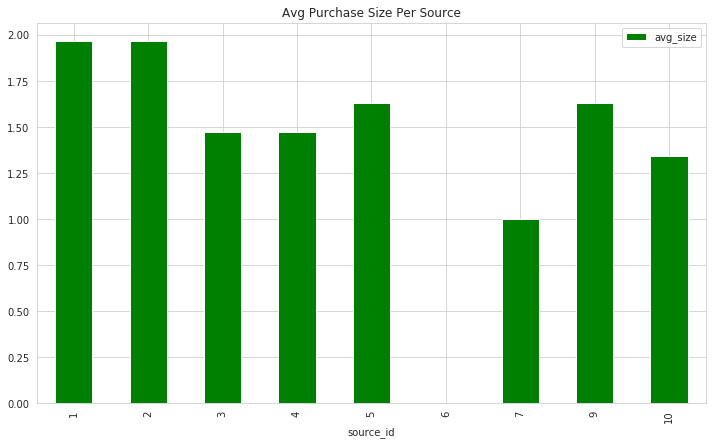

In [77]:
#The average purchase per platform

orders_size_per_source = orders_source.pivot_table(index='source_id', values=['uid','buy_ts'], aggfunc={'uid':'nunique','buy_ts':'nunique'})
orders_size_per_source['avg_size'] = orders_size_per_source['buy_ts']/orders_size_per_source['uid']
orders_size_per_source.drop(columns=['buy_ts','uid'], inplace=True)

orders_size_per_source.plot(kind='bar', figsize=(12,7), legend=True, title='Avg Purchase Size Per Source', grid=True, color='green')
plt.show()

The highest average purchase size is from sources 1 and 2.
after them there are sources 5 and 9.

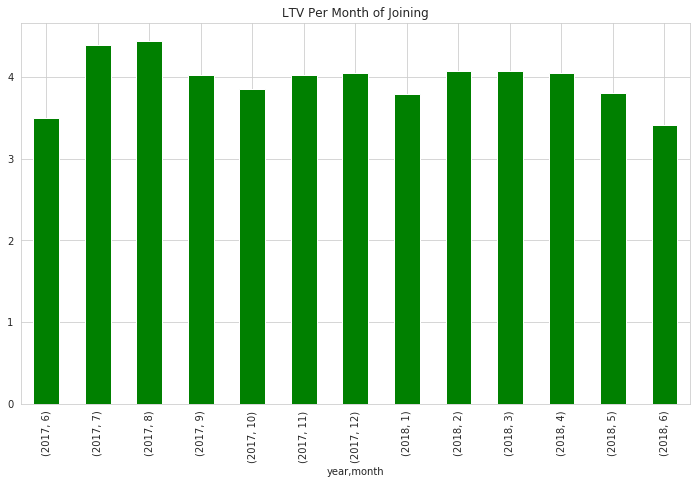

In [78]:
#Calculating LTV 

orders_fixed.head()

unqiue_per_month_table = orders_fixed.pivot_table(index=['year','month'], values=['uid','revenue'], aggfunc={'uid':'nunique','revenue':'sum'})
unqiue_per_month_table.columns = ['revenue','unique_per_month']
unqiue_per_month_table['ltv'] = unqiue_per_month_table['revenue']/unqiue_per_month_table['unique_per_month']
unqiue_per_month_table['ltv'].plot(kind='bar', color='green', figsize=(12,7), title='LTV Per Month of Joining')
plt.show()

The LTV for almost all the cohorts stands at around 4 dollars. (June 2017/2018 was 3.5 dollars)

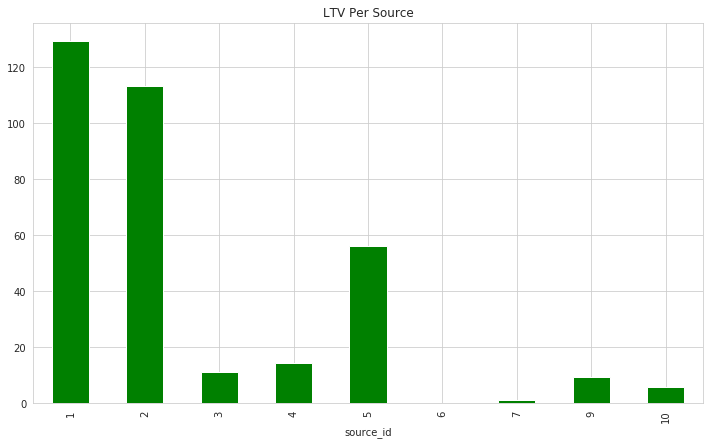

In [79]:
visits_for_ltv = visits_logs[['uid', 'source_id']]

orders_for_ltv = pd.merge(orders_fixed, visits_for_ltv, on='uid', how='inner')

unqiue_per_source = orders_for_ltv.pivot_table(index='source_id', values=['uid','revenue'], aggfunc={'uid':'nunique','revenue':'sum'})
unqiue_per_source.columns = ['revenue','unique_per_month']
unqiue_per_source['ltv'] = unqiue_per_source['revenue']/unqiue_per_source['unique_per_month']
unqiue_per_source['ltv'].plot(kind='bar', color='green', figsize=(12,7), title='LTV Per Source')
plt.show()

The sources with the best LTV are 1 (130 dollars), 2(115 dollars) and 5(~57 dollars).

### Conclusion

 - Since July 2017 there has been a decrease in the average time to convert for each monthly cohort.


 - The most converting cohorts were March and May 2018.


 - The Biggest marketing sources haven't changed between the best and worst cohorts. That means that the change in the conversion is due to the marketing team creative work or the fact the people feel more confident to make an order after the site is well known. 


 - The most converting sources are 1,2 and 5


 - The worst converting sources are 9 and 10 following 3 and 4.


 - July and September 2017 needed the least time to be on the site before converting. The marketing team should check the website design and if something had changed   


 - In almost all the sources the customers needed around 800 seconds on site before making a purchase (except for source 7 which needed 7000 seconds on site)


 - There is a small increase in order size in Spetember 2017 cohort following a big increase in the lster cohorts until March 2018. This increase in maybe due to the beginning of winter season where people prefer to hang out in closed placed rather open places. 


 - Sources 3 and 4 had the most orders from them. Following sources 5,2 and 1.


 - The average purchase size for all the cohorts stands at around 1.1 


 - The highest average purchase size is from sources 1 and 2. After them there are sources 5 and 9.


 - The LTV for almost all the cohorts stands at around 4 dollars. (June 2017/2018 was 3.5 dollars)


 - The sources with the best LTV are 1 (130 dollars), 2(115 dollars) and 5(~57 dollars).

## Marketing

Total Marketing Cost: 259995



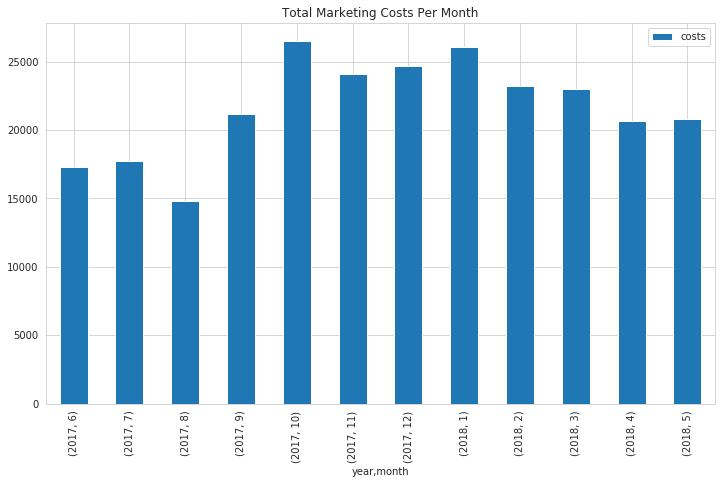

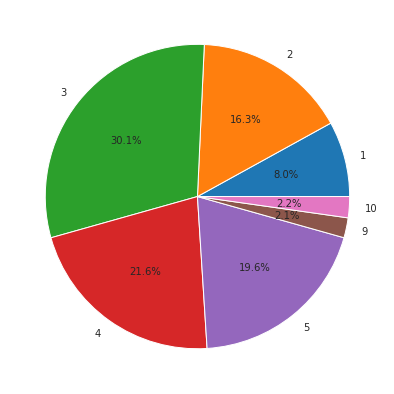

In [80]:
#Marketing - How much money was spent? Overall/per source/over time

marketing_fixed['month'] = marketing_fixed['dt'].dt.month
marketing_fixed['year'] = marketing_fixed['dt'].dt.year

total_marketing_sum = marketing_fixed['costs'].sum()
per_source = marketing_fixed.pivot_table(index='source_id', values='costs', aggfunc='sum').reset_index()
per_month = marketing_fixed.pivot_table(index=['year','month'], values='costs', aggfunc='sum')

print("Total Marketing Cost:", round(total_marketing_sum))
print()

per_month.plot(kind='bar', figsize=(12,7), title='Total Marketing Costs Per Month')
plt.show()

#px.pie(data_frame=per_source, values='costs', names='source_id',title='Cost Distrbution Per Source')
plt.figure(figsize=(15,7))
plt.pie(per_source['costs'], labels=per_source['source_id'],autopct='%1.1f%%')
plt.show()

#sometimes the plotly graph won't show up, try to restrat kernel and run all

Most of the marketing budget goes on sources 3 and 4 (more than 50%) although these are not the mest marketing channels we can use.

In September 2017 there has been an incrase in marketing expenses which lead to the increase in the amount of orders that were placed. 

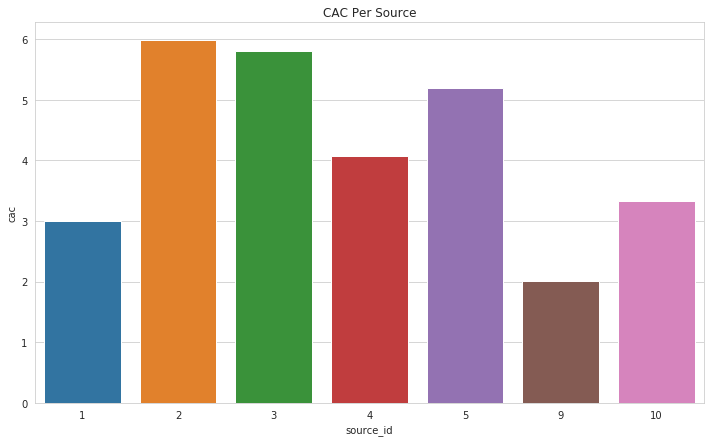

In [81]:
#How much did customer acquisition from each of the sources cost?

visits_for_cac = visits_logs[['uid', 'source_id']]

orders_for_cac = pd.merge(orders_fixed, visits_for_cac, on='uid', how='inner')

#calculating numbers of orders from each source and the sum of costs for each source
orders_for_cac = orders_for_cac.pivot_table(index='source_id', values='uid', aggfunc='nunique').drop(columns='source_id').reset_index()
marketing_for_cac = marketing_fixed.pivot_table(index='source_id', values='costs', aggfunc='sum').reset_index()

cac_table = pd.merge(orders_for_cac,marketing_for_cac,how='inner', on='source_id')

cac_table['cac'] = cac_table['costs']/cac_table['uid']

plt.figure(figsize=(12,7))
sns.barplot(x='source_id',y='cac',data=cac_table).set(title='CAC Per Source')
plt.show()

the sources with the highest CAC are: 2, 3, and 5

the sources with the lowest CAC are: 9,1 and 4 



In [82]:
#How worthwhile where the investments? (ROI)

unqiue_per_source = unqiue_per_source.reset_index()

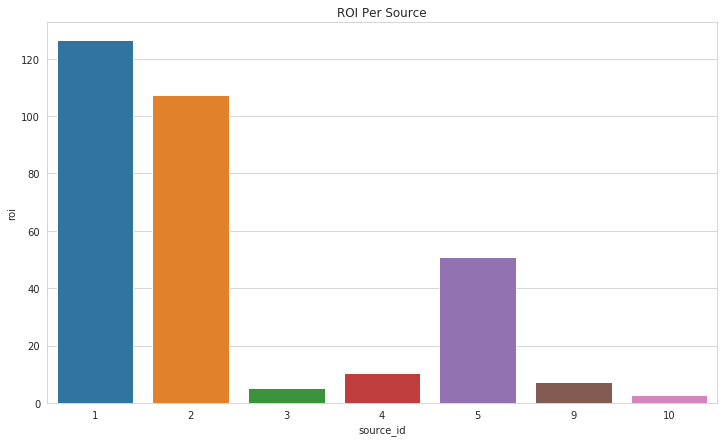

In [83]:
ROI_table = pd.merge(unqiue_per_source,cac_table, how='inner', on='source_id')

ROI_table['roi'] = ROI_table['ltv'] - ROI_table['cac']
ROI_table

plt.figure(figsize=(12,7))
sns.barplot(x='source_id', y='roi', data=ROI_table).set(title='ROI Per Source')
plt.show()

The best ROI is from channels 1, 2, and 5. 

### Conclusion

 - Most of the marketing budget goes on sources 3 and 4 (more than 50%) although these are not the mest marketing channels we can use.


 - In September 2017 there has been an incrase in marketing expenses which lead to the increase in the amount of orders that were placed.
 
 
 - The sources with the highest CAC are: 2, 3, and 5


 - The sources with the lowest CAC are: 9,1 and 4
 
 
 - The best ROI is from channels 1, 2, and 5.

# Final Conclusion

#### My recommendation to the marketing team is:

1. If possible to reach all of our target audience threw ad sources: 1, 2 and 5, change the marketing strategy to focus only on these sources. If not possible to reach all the target audience shift the main focus to these sources (at least 50% of the budget). Out of these sources, source number 1 has the best ROI, so if we can use only that channel it would be great (Kylie Jenner used only Instagram to build a business empire). 

*The metric i focues on is the ROI metric. as it takes into account the income from the client and the expenses of getting the client.

#### Sum up of all the conclusions:

-  Daily Active Users on Avg: 907


 -  Weekly Active Users on Avg: 5716


 -  Monthly Active Users on Avg: 23228


 -  Avg Number of Session per Day 987


 -  Avg Number of Unique Session per Day 907


 -  Average Session Time: 621 seconds (10.35 minutes)


 -  3.91% of the daily users come back each month


 -  15.88 % of the daily users come back each week
 
 
 - Since July 2017 there has been a decrease in the average time to convert for each monthly cohort.


 - The most converting cohorts were March and May 2018.


 - The Biggest marketing sources haven't changed between the best and worst cohorts. That means that the change in the conversion is due to the marketing team creative work or the fact the people feel more confident to make an order after the site is well known. 


 - The most converting sources are 1,2 and 5


 - The worst converting sources are 9 and 10 following 3 and 4.


 - July and September 2017 needed the least time to be on the site before converting. The marketing team should check the website design and if something had changed   


 - In almost all the sources the customers needed around 800 seconds on site before making a purchase (except for source 7 which needed 7000 seconds on site)


 - There is a small increase in order size in Spetember 2017 cohort following a big increase in the lster cohorts until March 2018. This increase in maybe due to the beginning of winter season where people prefer to hang out in closed placed rather open places. 


 - Sources 3 and 4 had the most orders from them. Following sources 5,2 and 1.


 - The average purchase size for all the cohorts stands at around 1.1 


 - The highest average purchase size is from sources 1 and 2. After them there are sources 5 and 9.


 - The LTV for almost all the cohorts stands at around 4 dollars. (June 2017/2018 was 3.5 dollars)


 - The sources with the best LTV are 1 (130 dollars), 2(115 dollars) and 5(~57 dollars).
 
 
  - Most of the marketing budget goes on sources 3 and 4 (more than 50%) although these are not the mest marketing channels we can use.


 - In September 2017 there has been an incrase in marketing expenses which lead to the increase in the amount of orders that were placed.
 
 
 - The sources with the highest CAC are: 2, 3, and 5


 - The sources with the lowest CAC are: 9,1 and 4
 
 
 - The best ROI is from channels 1, 2, and 5.